# Movies: Turbulent jet and Internal Tide configuration

In [2]:
from glob import glob

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as op
import crocosi.plot as cplt

In [3]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.68:55577 Dashboard: http://10.148.1.68:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load data

In [19]:
#root_path = '/home1/datawork/aponte/'
#root_path = '/home1/scratch/aponte/'
root_path = '/home/c11-data/Test_aponte/jetn/'

#run = 'jet_cfg1_wp5_4km_0a1000j/'
run = 'jet_cfg1_wp8_4km_0a1000j/'

r = pp.Run(root_path+run, open_nc=['surf'], 
           verbose=True)

r['surf'] = r['surf'].assign_coords(time=r['surf'].time_instant.chunk({'time':None}))

Analysing directory /home/c11-data/Test_aponte/jetn/jet_cfg1_wp8_4km_0a1000j/
Found 10 segments
Found 20 surf files
Found 10 grid files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['surf', 'grid']
Grid size: (L ,M, N) = (258, 722, 50)


---

## utils

In [5]:
def get_xy_coords_names(da):
    xc = next((x for x in da.dims if x[0]=='x'), False)
    yc = next((x for x in da.dims if x[0]=='y'), False)
    return xc, yc

def atom_1v(ax, da0, ax_kwargs={}, test=None, kw0={}, **kwargs):
    #
    xc, yc = get_xy_coords_names(da0)
    da0 = da0.assign_coords(x=da0[xc]/1e3, y=da0[yc]/1e3)
    #
    d = int(da0.time)
    title = da0.name+' day = %d'%(d)
    #h = (_da.time-d)*24
    #title = da.name+' day = %d / h = %.2f hour '%(d, h)
    #
    da0.plot(x='x',y='y', ax=ax, **kw0)
    #plot_Fy(pout, ax=ax, scale=1e-3)
    ax.set_aspect('equal', 'box')
    ax.set(**ax_kwargs)
    ax.set_title(title)
    
def atom_2v(ax, da0, da1, ax_kwargs={}, test=None, kw0={}, kw1={}, **kwargs):
    #
    xc, yc = get_xy_coords_names(da0)
    da0 = da0.assign_coords(x=da0[xc]/1e3, y=da0[yc]/1e3)
    xc, yc = get_xy_coords_names(da1)
    da1 = da1.assign_coords(x=da1[xc]/1e3, y=da1[yc]/1e3)
    #
    d = int(da0.time)
    title = da0.name+' day = %d'%(d)
    #h = (_da.time-d)*24
    #title = da.name+' day = %d / h = %.2f hour '%(d, h)
    #
    da0.plot(x='x',y='y', ax=ax, **kw0)
    da1.plot.contour(x='x',y='y', ax=ax, **kw1)
    #plot_Fy(pout, ax=ax, scale=1e-3)
    ax.set_aspect('equal', 'box')
    ax.set(**ax_kwargs)
    ax.set_title(title)    

---

### relative vorticity

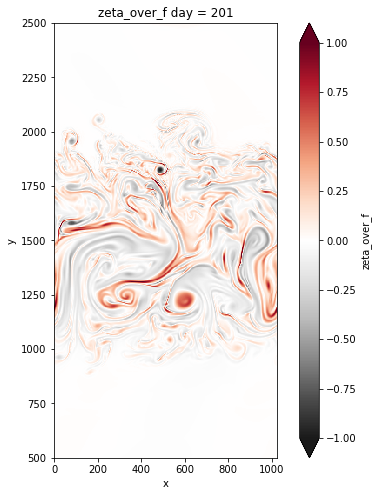

In [20]:
# 
u, v = r['surf']['u'], r['surf']['v']
zeta = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))

f_rho = r['grid'].f + r['grid'].x_rho*0.
f_zeta = r.xgrid.interp(r.xgrid.interp(f_rho, 'eta'), 'xi')
zeta_over_f = (zeta/f_zeta) .rename('zeta_over_f')

ssh = r['surf'].ssh.persist() # don't know why this helps speeding up

#
da0 = zeta_over_f

kw0 = {'vmin': -1., 'vmax': 1.,
       'cmap': 'RdGy_r', 
       'extend':'both'}

ax_kw = {'ylim': (500, 2500)}

cplt.movie_figure(atom_1v, da0, i=200, test=True, figsize=(8,8), 
                  ax_kwargs=ax_kw, **{'kw0': kw0})

#cplt.movie_figure(atom_2v, da0, da1, i=200, test=True, figsize=(8,8), 
#                  ax_kwargs=ax_kw, **{'kw0': kw0, 'kw1':kw1})

In [21]:
cplt.movie_wrapper(atom_1v, client, 
                   da0,
                   figsize=(8,8),
                   ax_kwargs=ax_kw, **{'kw0': kw0})

17 batches to be done
 batch 0-58
 batch 59-117
 batch 118-176
 batch 177-235
 batch 236-294
 batch 295-353
 batch 354-412
 batch 413-471
 batch 472-530
 batch 531-589
 batch 590-648
 batch 649-707
 batch 708-766
 batch 767-825
 batch 826-883
 batch 884-941
 batch 942-999


### with ssh overlaid

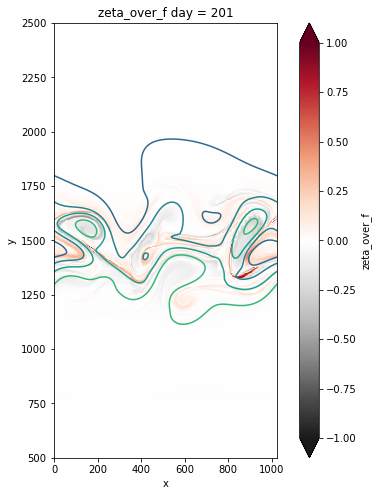

In [11]:
da1 = ssh
kw1 = {'vmin': -.7, 'vmax': .7,  # mean is 0.01
       'levels': 10}

cplt.movie_figure(atom_2v, da0, da1, i=200, test=True, figsize=(8,8), 
                  ax_kwargs=ax_kw, **{'kw0': kw0, 'kw1':kw1})

---

### sea level

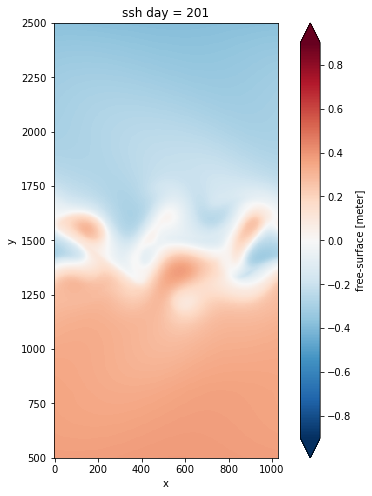

In [17]:
da0 = ssh

kw0 = {'vmin': -.9, 'vmax': .9,
       'cmap': 'RdBu_r', 
       'extend':'both'}

cplt.movie_figure(atom_1v, da0, i=200, test=True, figsize=(8,8), 
                  ax_kwargs=ax_kw, **{'kw0': kw0})

In [18]:
cplt.movie_wrapper(atom_1v, client, 
                   da0,
                   figsize=(8,8),
                   ax_kwargs=ax_kw, **{'kw0': kw0})

17 batches to be done
 batch 0-58
 batch 59-117
 batch 118-176
 batch 177-235
 batch 236-294
 batch 295-353
 batch 354-412
 batch 413-471
 batch 472-530
 batch 531-589
 batch 590-648
 batch 649-707
 batch 708-766
 batch 767-825
 batch 826-883
 batch 884-941
 batch 942-999


---

In [69]:
cluster.close()